# forest_embeddings

## Experimenting with forest-based data representations

Let us try out a new way to represent data and perform clustering: forest embeddings. A forest embedding is a way to represent a feature space using a random forest. Each sample $x_i$ in the data is encoded as a vector $x_i = [e_0, e_1, ..., e_k]$ where each element $e_i$ holds which leaf of tree $i$ in the forest $x_i$ ended up into. The encoding can be learned in a supervised or unsupervised manner:

1. **Supervised:** we train a forest to solve a regression or classification problem. Then, we use its trees structure to extract the embedding. 

2. **Unsupervised:** each tree of the forest builds splits at random, without using a target variable.

There may be a number of benefits in using forest-based embeddings:

1. **Distance calculations are ok when there are categorical variables:** as we're using leaf co-ocurrence as our similarity, we do not need to be concerned that distance is not defined for categorical variables. 

2. **For supervised embeddings, we automatically set optimal weights for each feature for clustering:** if we want to cluster our data given a target variable, our embedding automatically selects the most relevant features.

3. **We do not need to worry about scaling features:** we do not need to worry about the scaling of the features, as we're using decision trees. 

Let us implement some models and check results on simple cases. 

In [1]:
# magics to make plots inline
%matplotlib inline

# importing relevant libraries
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier 
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor 
from sklearn.ensemble import RandomTreesEmbedding
from sklearn.manifold import TSNE
from sklearn.datasets import make_classification, make_moons, make_blobs, make_regression, load_diabetes, load_boston
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import cross_validate
from tqdm import tqdm

# turning off automatic plot showing, and setting style
plt.style.use('bmh')

## Embedding test pipeline

Let us implement a class to simplify evaluating our emdebbing models.

In [2]:
# class implementation
class ForestEmbedding:
    
    # initalization
    def __init__(self, model, X, y, reweight=False, cv_eval_metric='accuracy',
                 rte=RandomTreesEmbedding(n_estimators=100, max_depth=None, min_samples_leaf=2)):
        
        # storing our variables
        self.model = model
        self.X = X
        self.y = y
        self.reweight = reweight
        self.cv_eval_metric = cv_eval_metric
        
        # a unsupervised embedding for reweighting
        self.rte = rte
        
    # function to get distance matrix
    def get_distance_matrix(self, model, X, y):
        
        # fitting the model
        try:
            cv_score = 0.0
            model.fit(X)
        except TypeError:
            cv_score = cross_validate(model, X, y, scoring=self.cv_eval_metric)['test_score'].mean()
            model.fit(X, y)
        
        # let us apply to X
        leaves = model.apply(X)
        
        # let us get a distance matrix from these guys #

        # first, we apply a one-hot encoding scheme
        M = OneHotEncoder().fit_transform(leaves)

        # then, we perform M*M.transpose(), which is the same to 
        # computing all the pairwise co-ocurrences in the leaves 
        S = (M*M.transpose()).todense()

        # lastly, we normalize and subtract from 1, to get dissimilarities
        D = 1 - S/S.max()
        
        # returning
        return D, cv_score, model.feature_importances_
    
    # function for running model evaluation
    def get_embedding_eval(self):
        
        # distance matrix of our model
        D, cv_score, importances = self.get_distance_matrix(self.model, self.X, self.y)
        
        # reweighting distance of the model, if chosen
        if self.reweight:
            D_rte, _, __ = self.get_distance_matrix(self.rte, self.X, self.y)
            D = np.multiply(D, D_rte)
        
        # let us compute a tsne to visualize
        embed = TSNE(metric='precomputed', perplexity=30).fit_transform(D)
        
        # let us return a dictionary with the data
        return {'model': self.model, 
                'D': D, 
                'tsne_embed': embed, 
                'cv_score': np.round(cv_score,3),
                'importances':importances}

## Two blobs, two dimensions

Let us start with a dataset of two blobs in two dimensions.

##### First, let us generate and visualize the data

In [3]:
# let us generate the data
X, y = make_blobs(n_samples=1000, n_features=2, centers=2, random_state=42, cluster_std=1.0)

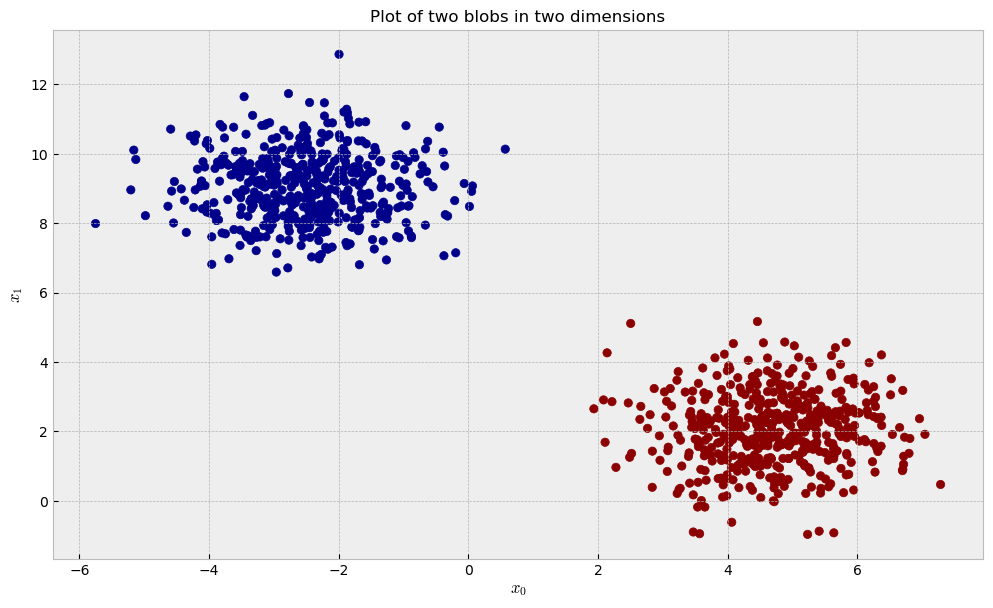

In [4]:
# let us visualize the clusters
plt.figure(figsize=(12,7), dpi=100);
plt.title('Plot of two blobs in two dimensions', fontsize=12)
plt.scatter(X[:,0], X[:,1], c=pd.Series(y).replace({0:'darkblue',1:'darkred'}))
plt.ylabel('$x_1$'), plt.xlabel('$x_0$');

##### Now, let us run our models 

In [5]:
# let us define our forest models for embedding
# starting with empty dict
models_dict = {}

# unsupervised
models_dict['rte'] = RandomTreesEmbedding(n_estimators=100, max_depth=None, min_samples_leaf=2)

# supervised, random forest
models_dict['rf'] = RandomForestClassifier(n_estimators=100, min_samples_leaf=10)

# supervised, extra trees
models_dict['et'] = ExtraTreesClassifier(n_estimators=100, min_samples_leaf=10)

In [6]:
# list of result dictionaries
results_list = []

# loop for each model
for key, model in tqdm(models_dict.items()):
    
    # starting up a experiment
    experiment = ForestEmbedding(model, X, y)
    
    # computing results
    results = experiment.get_embedding_eval()
    
    # adding model name
    results['model_name'] = key
    
    # storing
    results_list.append(results)

100%|██████████| 3/3 [01:39<00:00, 33.13s/it]


##### Let us visually inspect the similarities learned by the embedding 

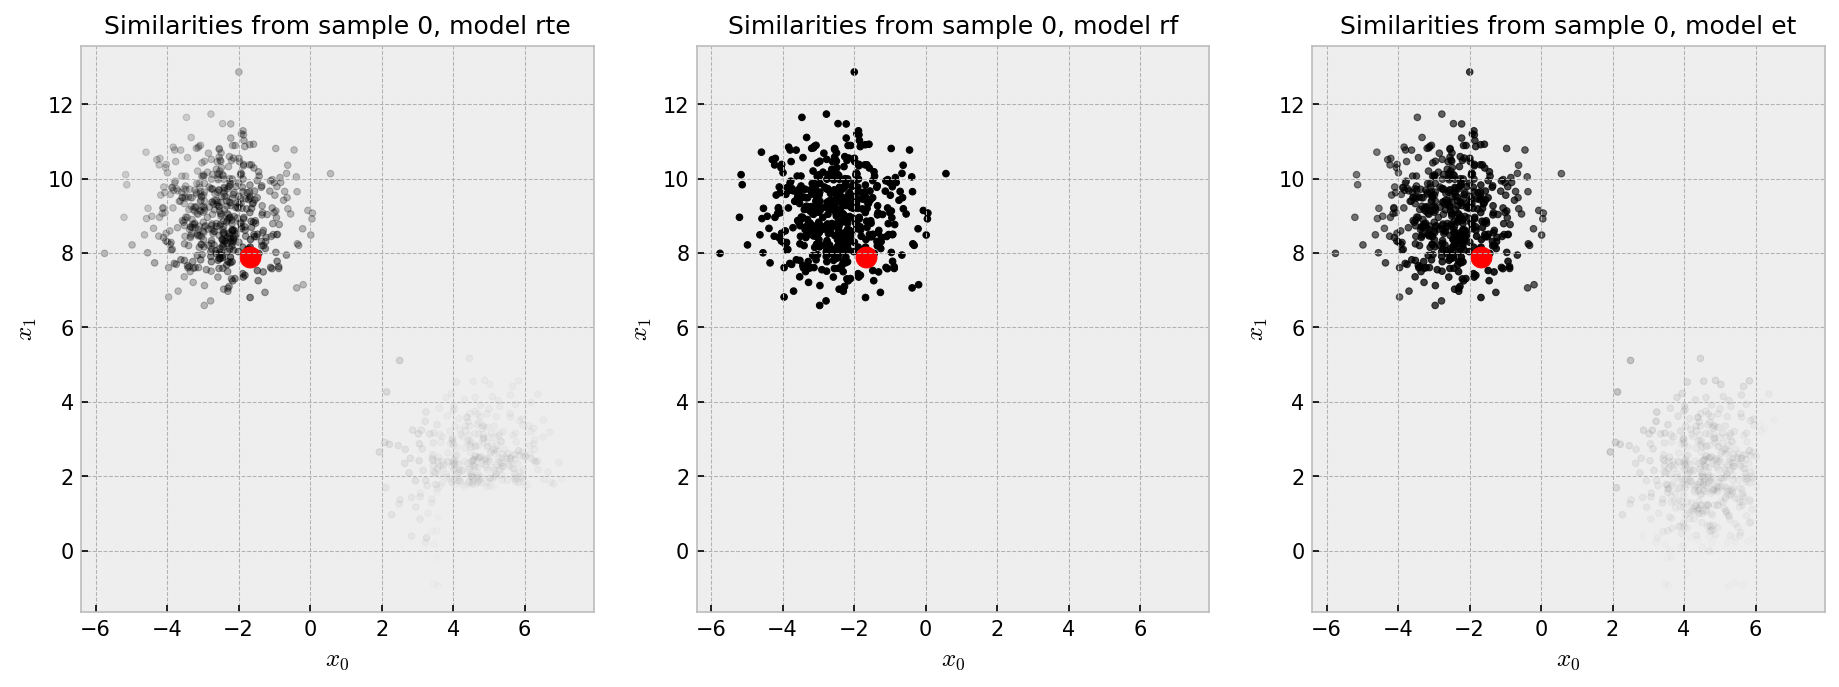

In [7]:
# which point will we inspect?
TARGET_SAMPLE = 0

# opening figure
plt.figure(figsize=(15,5), dpi=150);

# loop for each result
for i, results in enumerate(results_list):

    # current subplot
    plt.subplot(1, 3, i + 1)
    
    # let us define an array for color and alpha
    rgba_colors = np.zeros((X.shape[0], 4))
    rgba_colors[:,3] = MinMaxScaler().fit_transform(1 - results['D'][TARGET_SAMPLE, :].T).T[0]

    # let us visualize the clusters
    plt.title('Similarities from sample {0}, model {1}'.format(TARGET_SAMPLE, results['model_name']), fontsize=12)
    plt.scatter(X[:,0], X[:,1], color=rgba_colors, s=10)
    plt.scatter(X[TARGET_SAMPLE,0], X[TARGET_SAMPLE,1], c='red', s=100)
    plt.ylabel('$x_1$'), plt.xlabel('$x_0$');

##### Let us now check a t-SNE plot for our embedding distance matrix

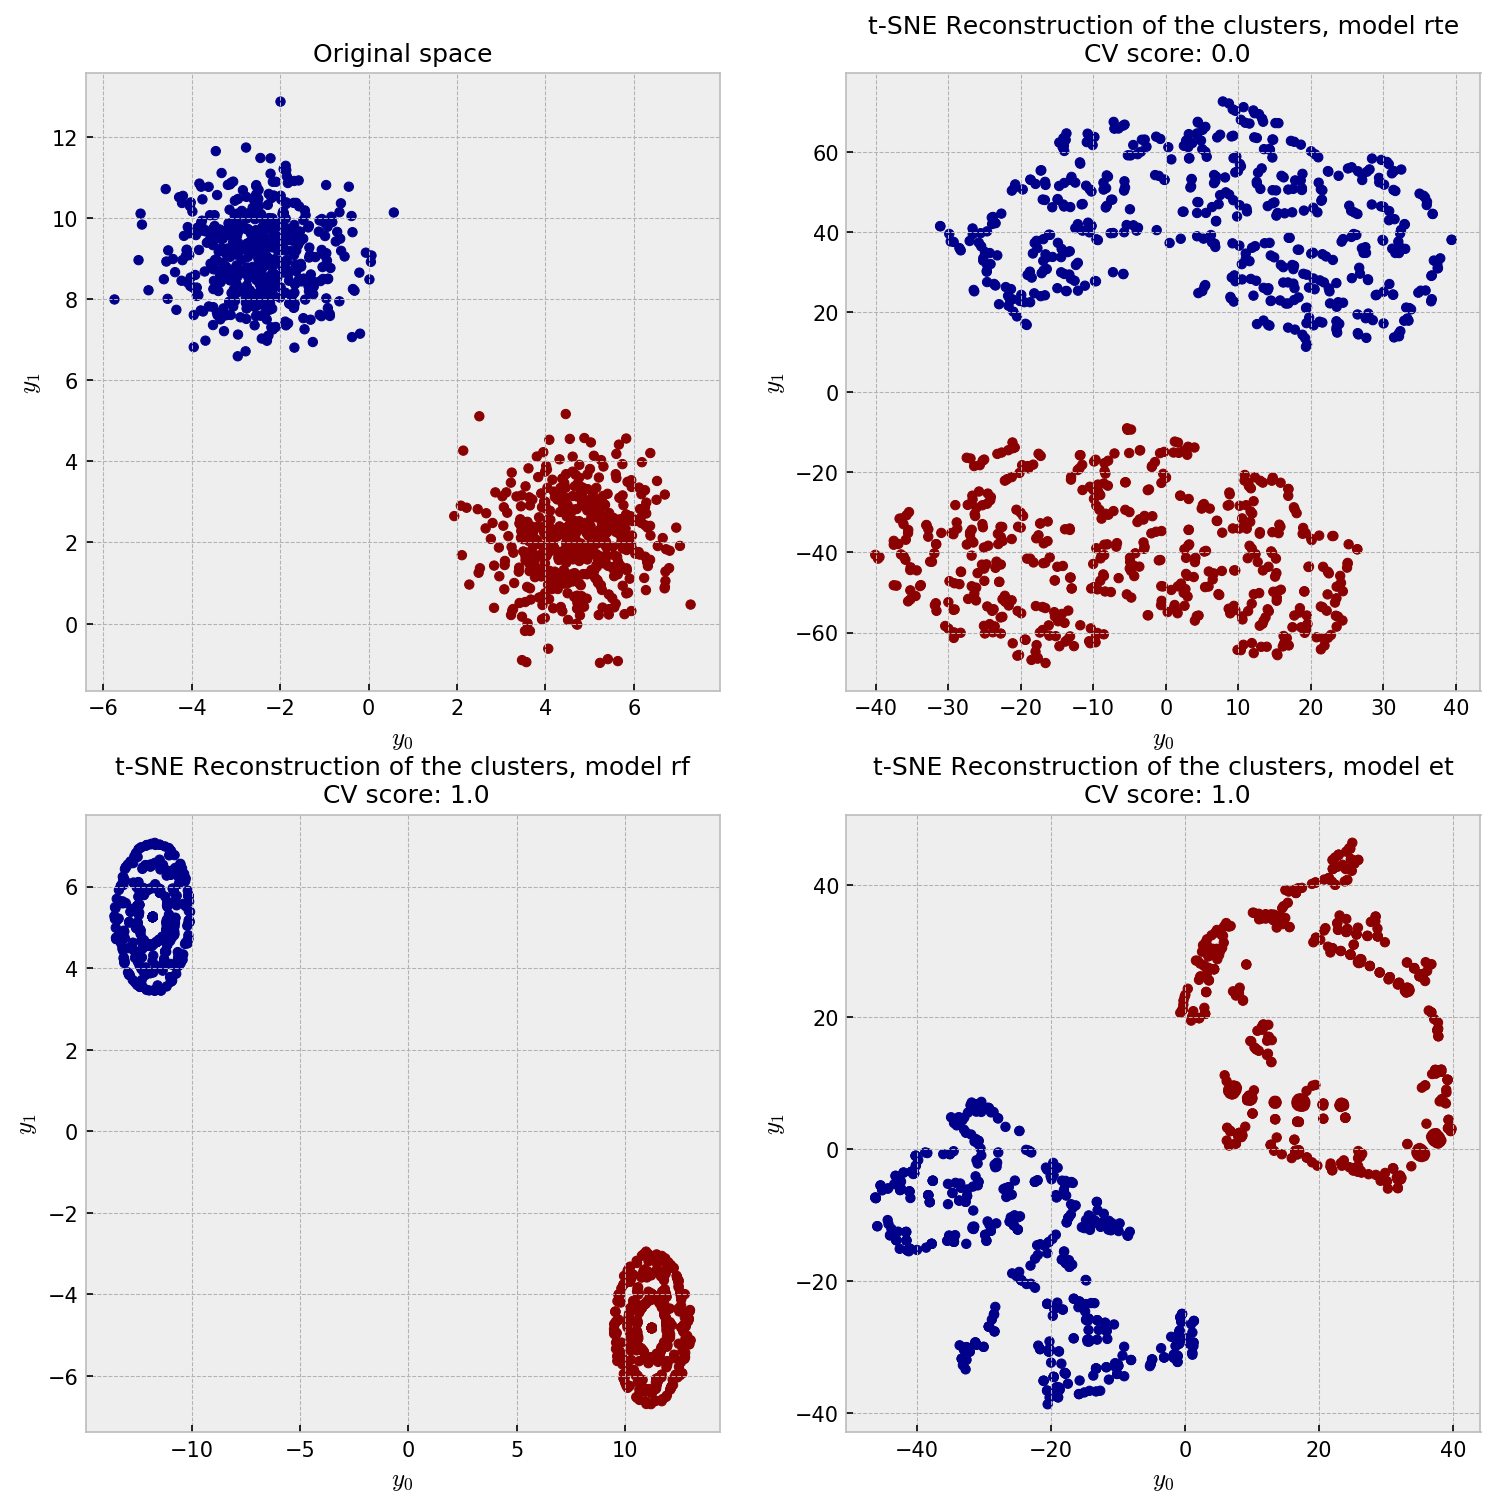

In [8]:
# opening figure
plt.figure(figsize=(12,12), dpi=150);

# first subplot is for drawing the original space
plt.subplot(2, 2, 1)

# let us visualize the clusters
plt.title('Original space', fontsize=12)
plt.scatter(X[:,0], X[:,1], c=pd.Series(y).replace({0:'darkblue',1:'darkred'}), s=20)
plt.ylabel('$y_1$'), plt.xlabel('$y_0$');

# loop for each result
for i, results in enumerate(results_list):

    # current subplot
    plt.subplot(2, 2, i + 2)
    
    # let us visualize the clusters
    plt.title('t-SNE Reconstruction of the clusters, model {0}\n CV score: {1}'.format(results['model_name'], results['cv_score']), fontsize=12)
    plt.scatter(results['tsne_embed'][:,0], results['tsne_embed'][:,1], c=pd.Series(y).replace({0:'darkblue',1:'darkred'}), s=20)
    plt.ylabel('$y_1$'), plt.xlabel('$y_0$');

We can see that all the embeddings give a reasonable reconstruction of the data, except for some artifacts on the ET reconstruction. Similarities by the RF are pretty much binary: points in the same cluster have 100% similarity to one another as opposed to points in different clusters which have zero similarity. ET and RTE have "softer" similarities. I'm not sure what exactly are the artifacts in the ET plot, but they may as well be the t-SNE "overfitting" the local structure, close to the artificial clusters shown in the gaussian noise example in [here](https://distill.pub/2016/misread-tsne/). 

## Two moons, two dimensions

Now, let us check a dataset of two moons in two dimensions.

##### As before, let us first generate and visualize the data

In [9]:
# let us generate the data
X, y = make_moons(n_samples=1000, random_state=42,noise=0.1)

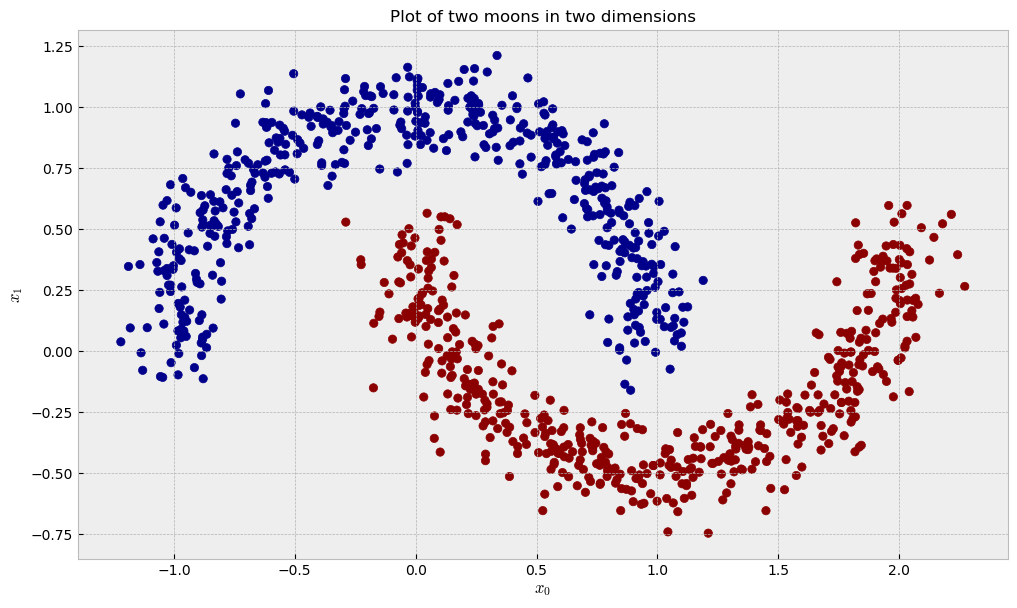

In [12]:
# let us visualize the clusters
plt.figure(figsize=(12,7), dpi=100);
plt.title('Plot of two moons in two dimensions', fontsize=12)
plt.scatter(X[:,0], X[:,1], c=pd.Series(y).replace({0:'darkblue',1:'darkred'}))
plt.ylabel('$x_1$'), plt.xlabel('$x_0$');

##### Running our models 

In [13]:
# let us define our forest models for embedding
# starting with empty dict
models_dict = {}

# unsupervised
models_dict['rte'] = RandomTreesEmbedding(n_estimators=100, max_depth=None, min_samples_leaf=2)

# supervised, random forest
models_dict['rf'] = RandomForestClassifier(n_estimators=100, min_samples_leaf=10)

# supervised, extra trees
models_dict['et'] = ExtraTreesClassifier(n_estimators=100, min_samples_leaf=10)

In [14]:
# list of result dictionaries
results_list = []

# loop for each model
for key, model in tqdm(models_dict.items()):
    
    # starting up a experiment
    experiment = ForestEmbedding(model, X, y)
    
    # computing results
    results = experiment.get_embedding_eval()
    
    # adding model name
    results['model_name'] = key
    
    # storing
    results_list.append(results)

100%|██████████| 3/3 [01:25<00:00, 28.62s/it]


##### Let us visually inspect the similarities learned by the embedding 

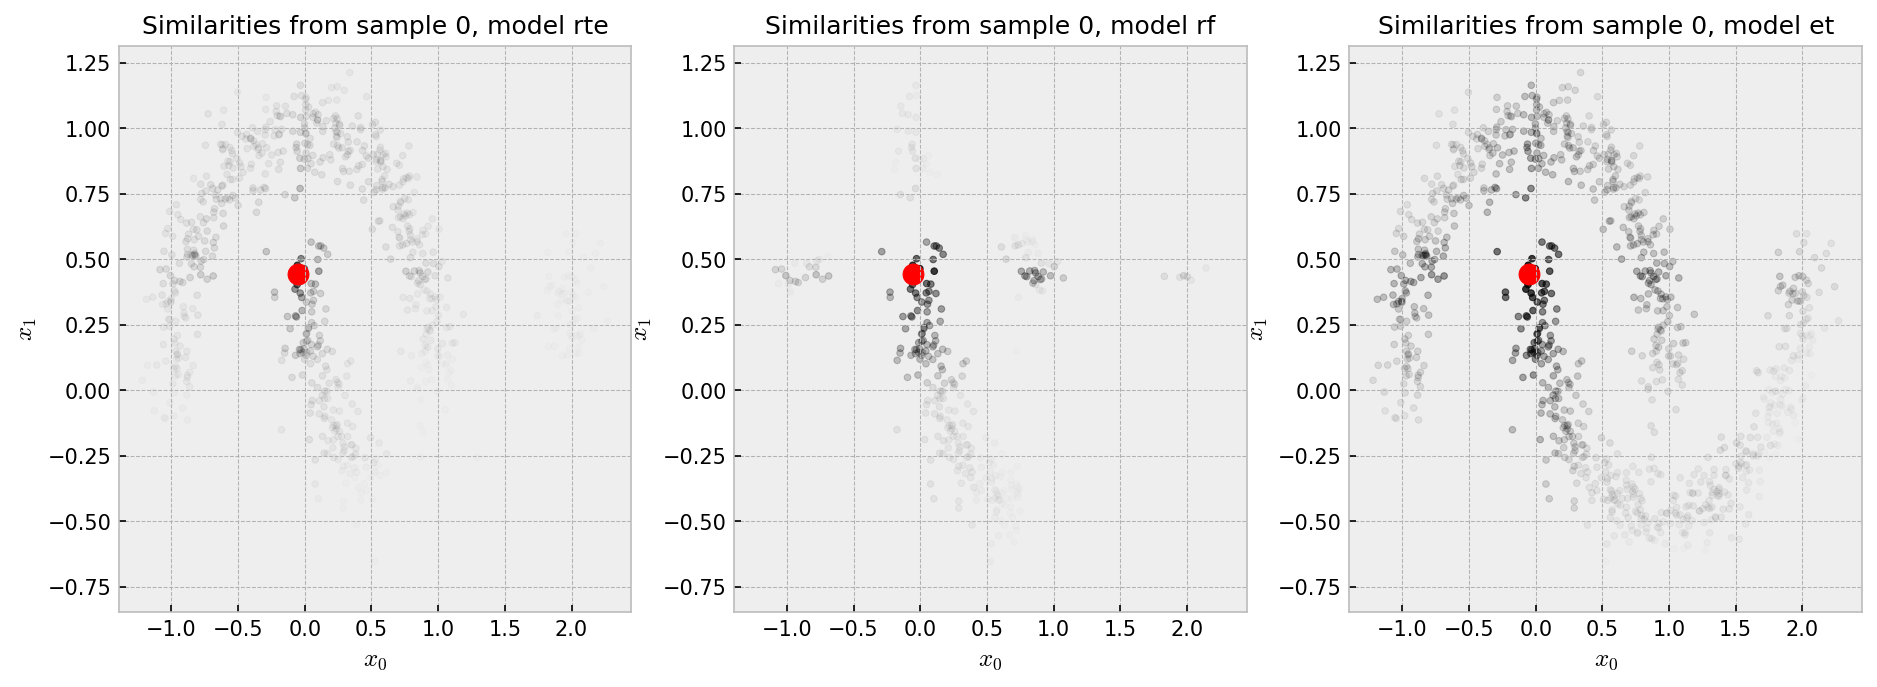

In [15]:
# which point will we inspect?
TARGET_SAMPLE = 0

# opening figure
plt.figure(figsize=(15,5), dpi=150);

# loop for each result
for i, results in enumerate(results_list):

    # current subplot
    plt.subplot(1, 3, i + 1)
    
    # let us define an array for color and alpha
    rgba_colors = np.zeros((X.shape[0], 4))
    rgba_colors[:,3] = MinMaxScaler().fit_transform(1 - results['D'][TARGET_SAMPLE, :].T).T[0]

    # let us visualize the clusters
    plt.title('Similarities from sample {0}, model {1}'.format(TARGET_SAMPLE, results['model_name']), fontsize=12)
    plt.scatter(X[:,0], X[:,1], color=rgba_colors, s=10)
    plt.scatter(X[TARGET_SAMPLE,0], X[TARGET_SAMPLE,1], c='red', s=100)
    plt.ylabel('$x_1$'), plt.xlabel('$x_0$');

##### Let us now check a t-SNE plot for our embedding distance matrix

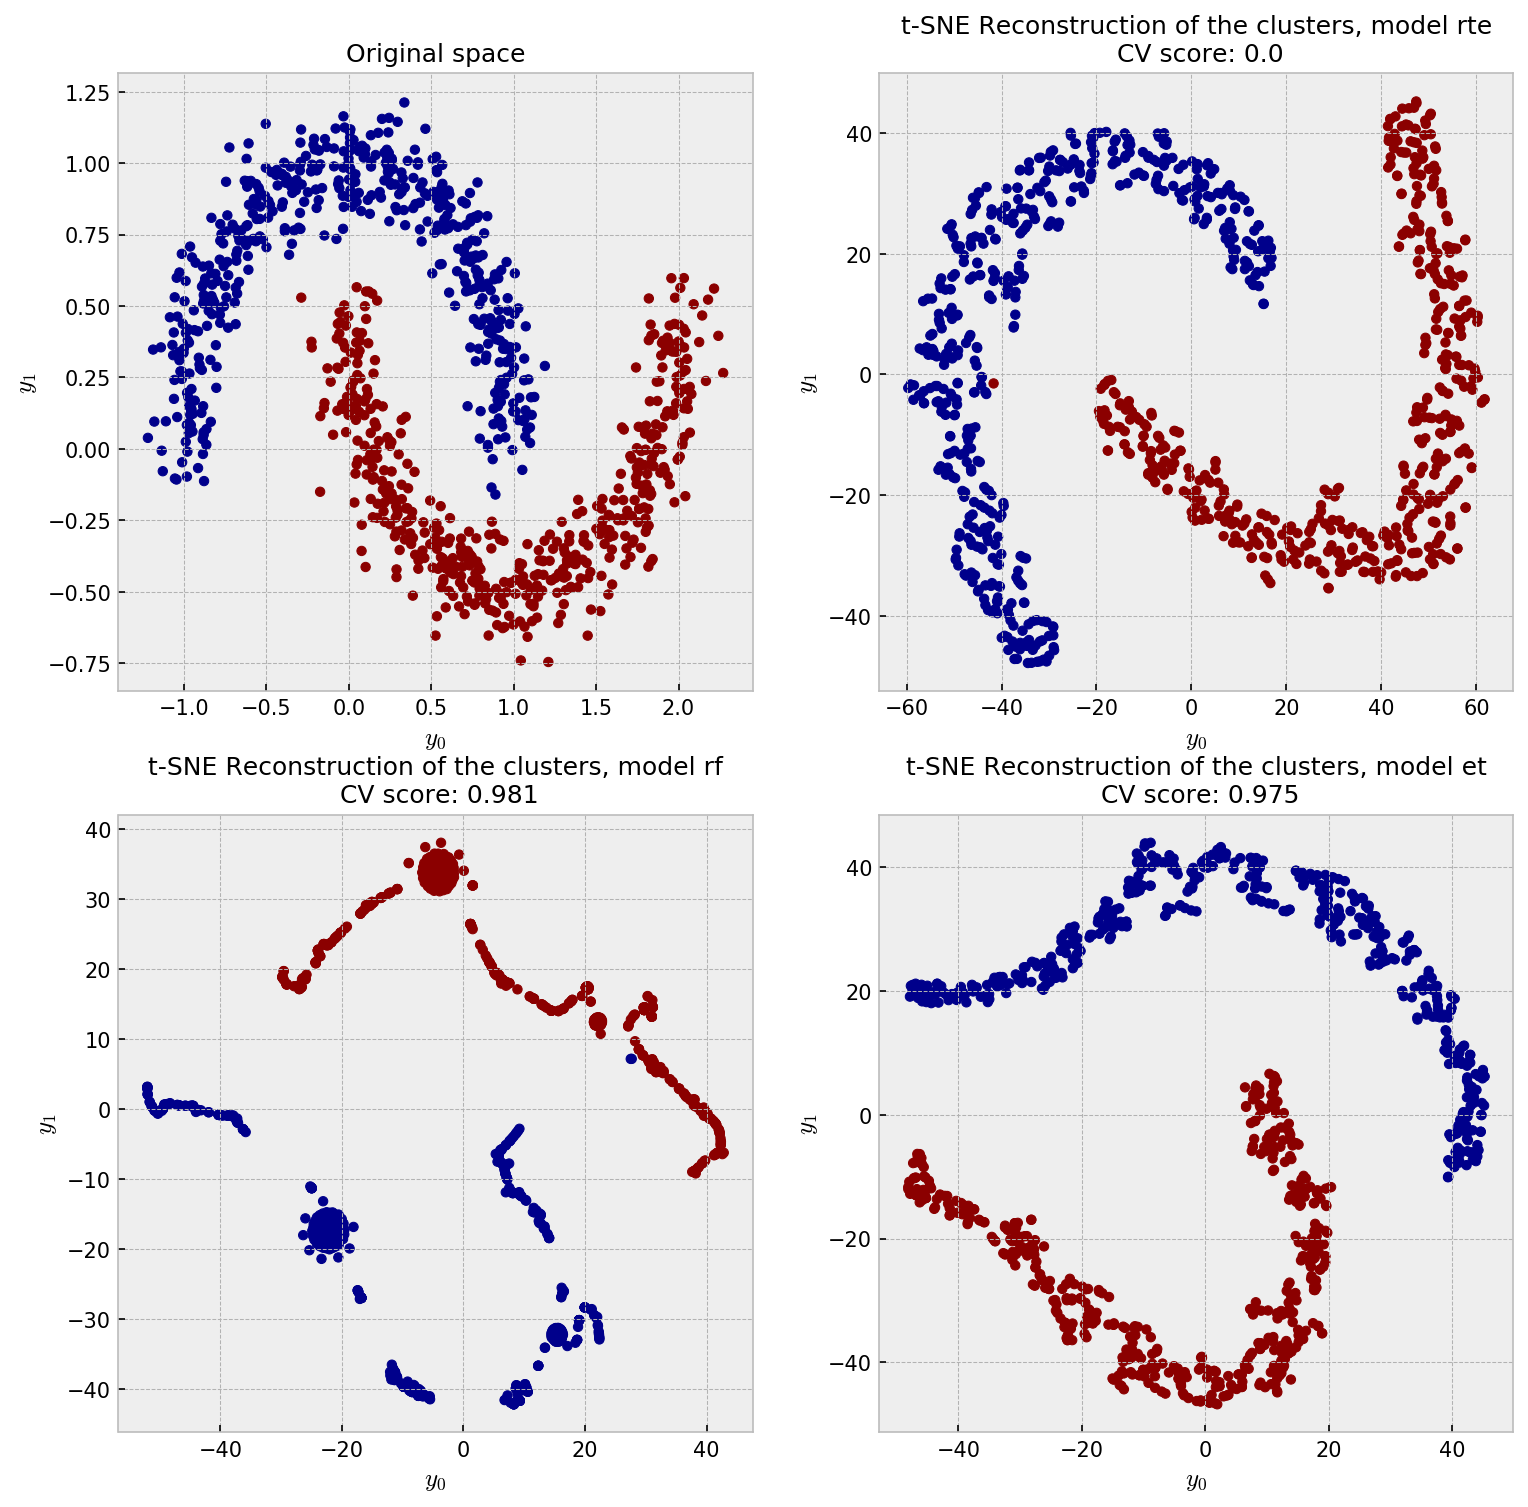

In [16]:
# opening figure
plt.figure(figsize=(12,12), dpi=150);

# first subplot is for drawing the original space
plt.subplot(2, 2, 1)

# let us visualize the clusters
plt.title('Original space', fontsize=12)
plt.scatter(X[:,0], X[:,1], c=pd.Series(y).replace({0:'darkblue',1:'darkred'}), s=20)
plt.ylabel('$y_1$'), plt.xlabel('$y_0$');

# loop for each result
for i, results in enumerate(results_list):

    # current subplot
    plt.subplot(2, 2, i + 2)
    
    # let us visualize the clusters
    plt.title('t-SNE Reconstruction of the clusters, model {0}\n CV score: {1}'.format(results['model_name'], results['cv_score']), fontsize=12)
    plt.scatter(results['tsne_embed'][:,0], results['tsne_embed'][:,1], c=pd.Series(y).replace({0:'darkblue',1:'darkred'}), s=20)
    plt.ylabel('$y_1$'), plt.xlabel('$y_0$');

RTE perfectly reconstucts the moon pattern, while ET unwraps the moons and RF shows a pretty strange plot. I think the ball-like shapes in the RF plot may correspond to regions in the space in which the samples could be perfectly classified in just one split, like, say, all the points in **$y_1 < -0.25$**. All of these points would have 100% similarity from one another. As ET draws splits less greedily, similarities are softer and we see a space that has a more uniform distribution of points.

## Four moons, where only two are relevant

Now, let us concatenate two datasets of moons, but we will only use the target variable of the first.

##### Now, let us generate two datasets like the last, but only use one target variable. We expect that the supervised models will better reconstruct the relevant clusters in the data

In [18]:
# let us generate the data
X1, y1 = make_moons(n_samples=1000, random_state=42, noise=0.1)
X2, y2 = make_moons(n_samples=1000, random_state=41, noise=0.1)

In [19]:
# let us add the random feature
X = np.c_[X1, X2]

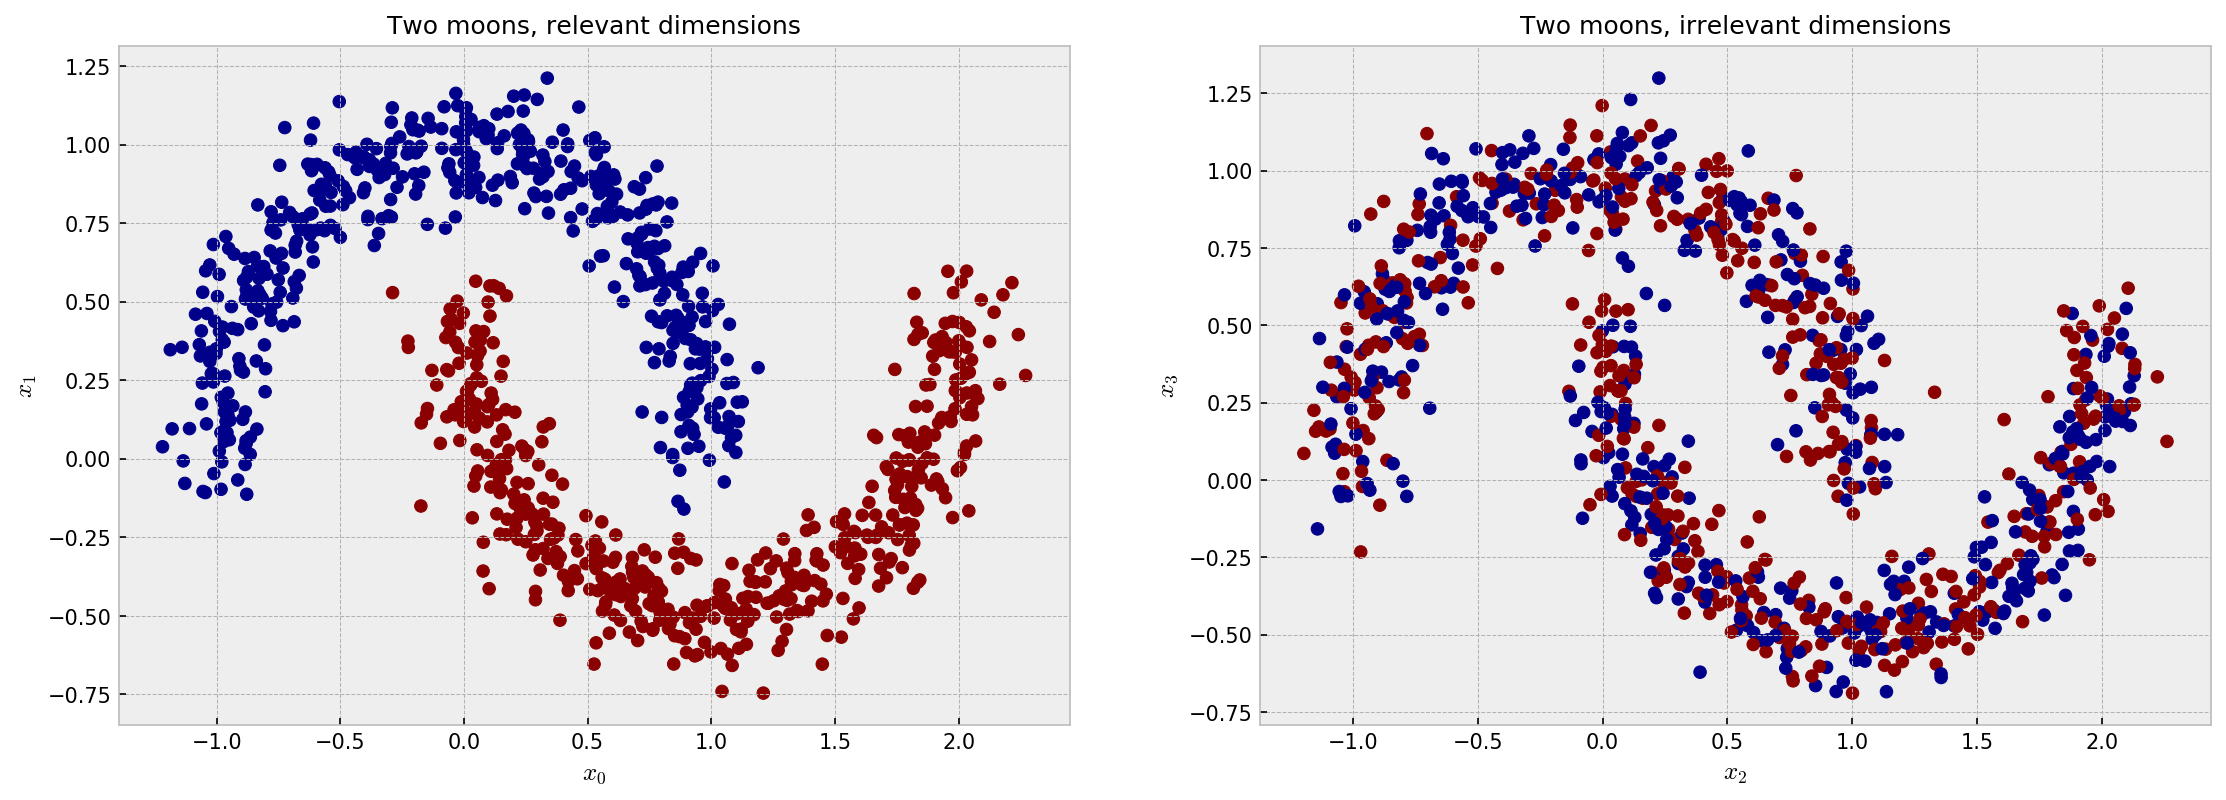

In [20]:
# let us visualize the clusters
plt.figure(figsize=(18,6), dpi=150);

# plot with relevant dimensions
plt.subplot(1, 2, 1)
plt.title('Two moons, relevant dimensions', fontsize=12)
plt.scatter(X[:,0], X[:,1], c=pd.Series(y1).replace({0:'darkblue',1:'darkred'}))
plt.ylabel('$x_1$'), plt.xlabel('$x_0$');

# plot with irrelevant dimension
plt.subplot(1, 2, 2)
plt.title('Two moons, irrelevant dimensions', fontsize=12)
plt.scatter(X[:,2], X[:,3], c=pd.Series(y1).replace({0:'darkblue',1:'darkred'}))
plt.ylabel('$x_3$'), plt.xlabel('$x_2$');

##### Now, let us run our models 

In [21]:
# let us define our forest models for embedding
# starting with empty dict
models_dict = {}

# unsupervised
models_dict['rte'] = RandomTreesEmbedding(n_estimators=100, max_depth=None, min_samples_leaf=2)

# supervised, random forest
models_dict['rf'] = RandomForestClassifier(n_estimators=100, min_samples_leaf=10)

# supervised, extra trees
models_dict['et'] = ExtraTreesClassifier(n_estimators=100, min_samples_leaf=10)

In [22]:
# list of result dictionaries
results_list = []

# loop for each model
for key, model in tqdm(models_dict.items()):
    
    # starting up a experiment
    experiment = ForestEmbedding(model, X, y1)
    
    # computing results
    results = experiment.get_embedding_eval()
    
    # adding model name
    results['model_name'] = key
    
    # storing
    results_list.append(results)

100%|██████████| 3/3 [01:28<00:00, 29.52s/it]


##### Let us visually inspect the similarities learned by the embedding 

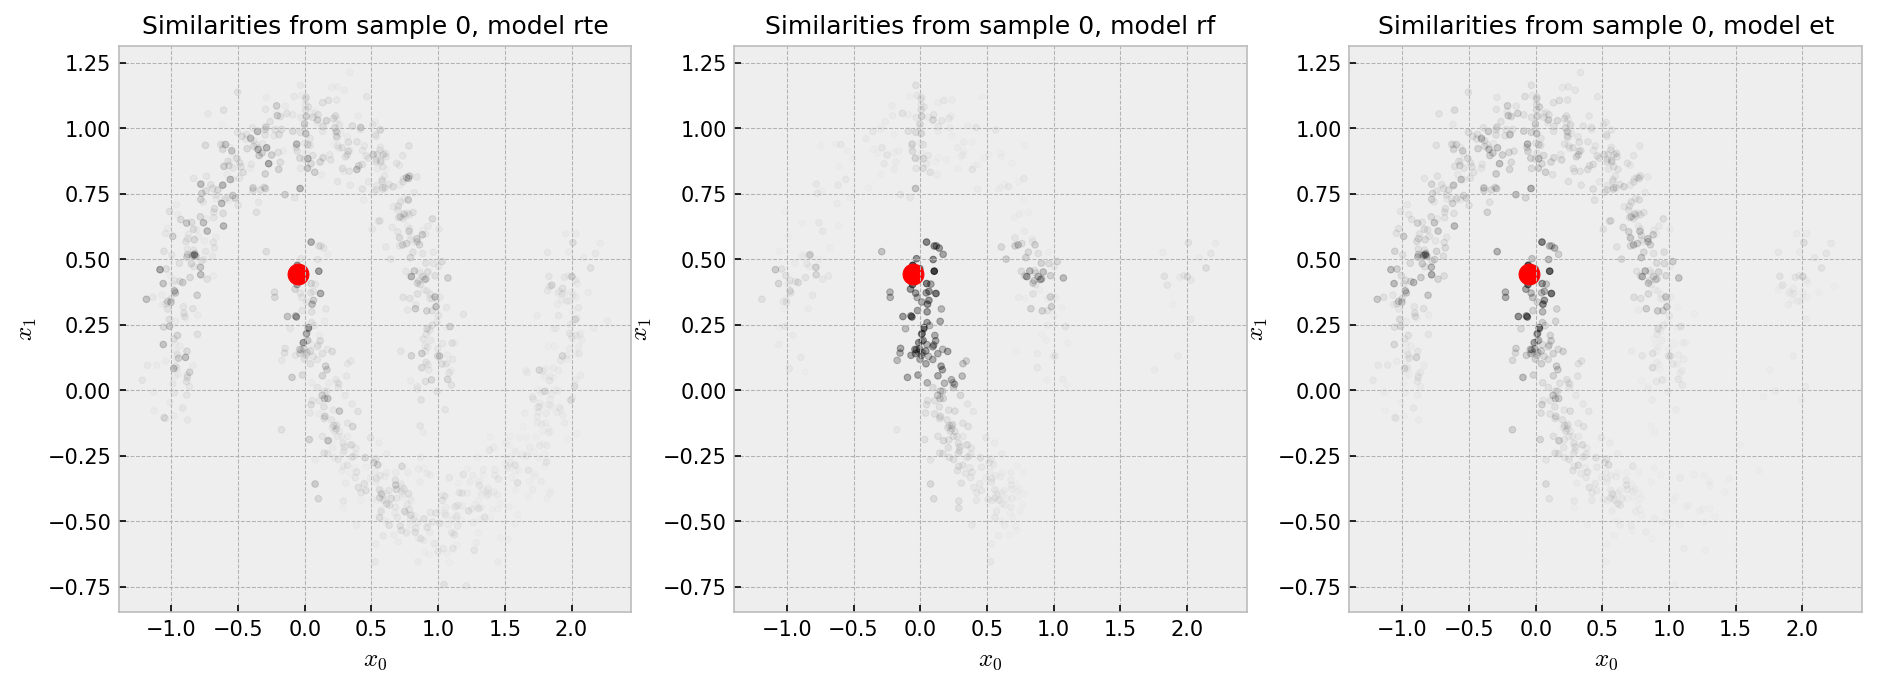

In [23]:
# which point will we inspect?
TARGET_SAMPLE = 0

# opening figure
plt.figure(figsize=(15,5), dpi=150);

# loop for each result
for i, results in enumerate(results_list):

    # current subplot
    plt.subplot(1, 3, i + 1)
    
    # let us define an array for color and alpha
    rgba_colors = np.zeros((X.shape[0], 4))
    rgba_colors[:,3] = MinMaxScaler().fit_transform(1 - results['D'][TARGET_SAMPLE, :].T).T[0]

    # let us visualize the clusters
    plt.title('Similarities from sample {0}, model {1}'.format(TARGET_SAMPLE, results['model_name']), fontsize=12)
    plt.scatter(X[:,0], X[:,1], color=rgba_colors, s=10)
    plt.scatter(X[TARGET_SAMPLE,0], X[TARGET_SAMPLE,1], c='red', s=100)
    plt.ylabel('$x_1$'), plt.xlabel('$x_0$');

##### Let us now check a t-SNE plot for our embedding distance matrix

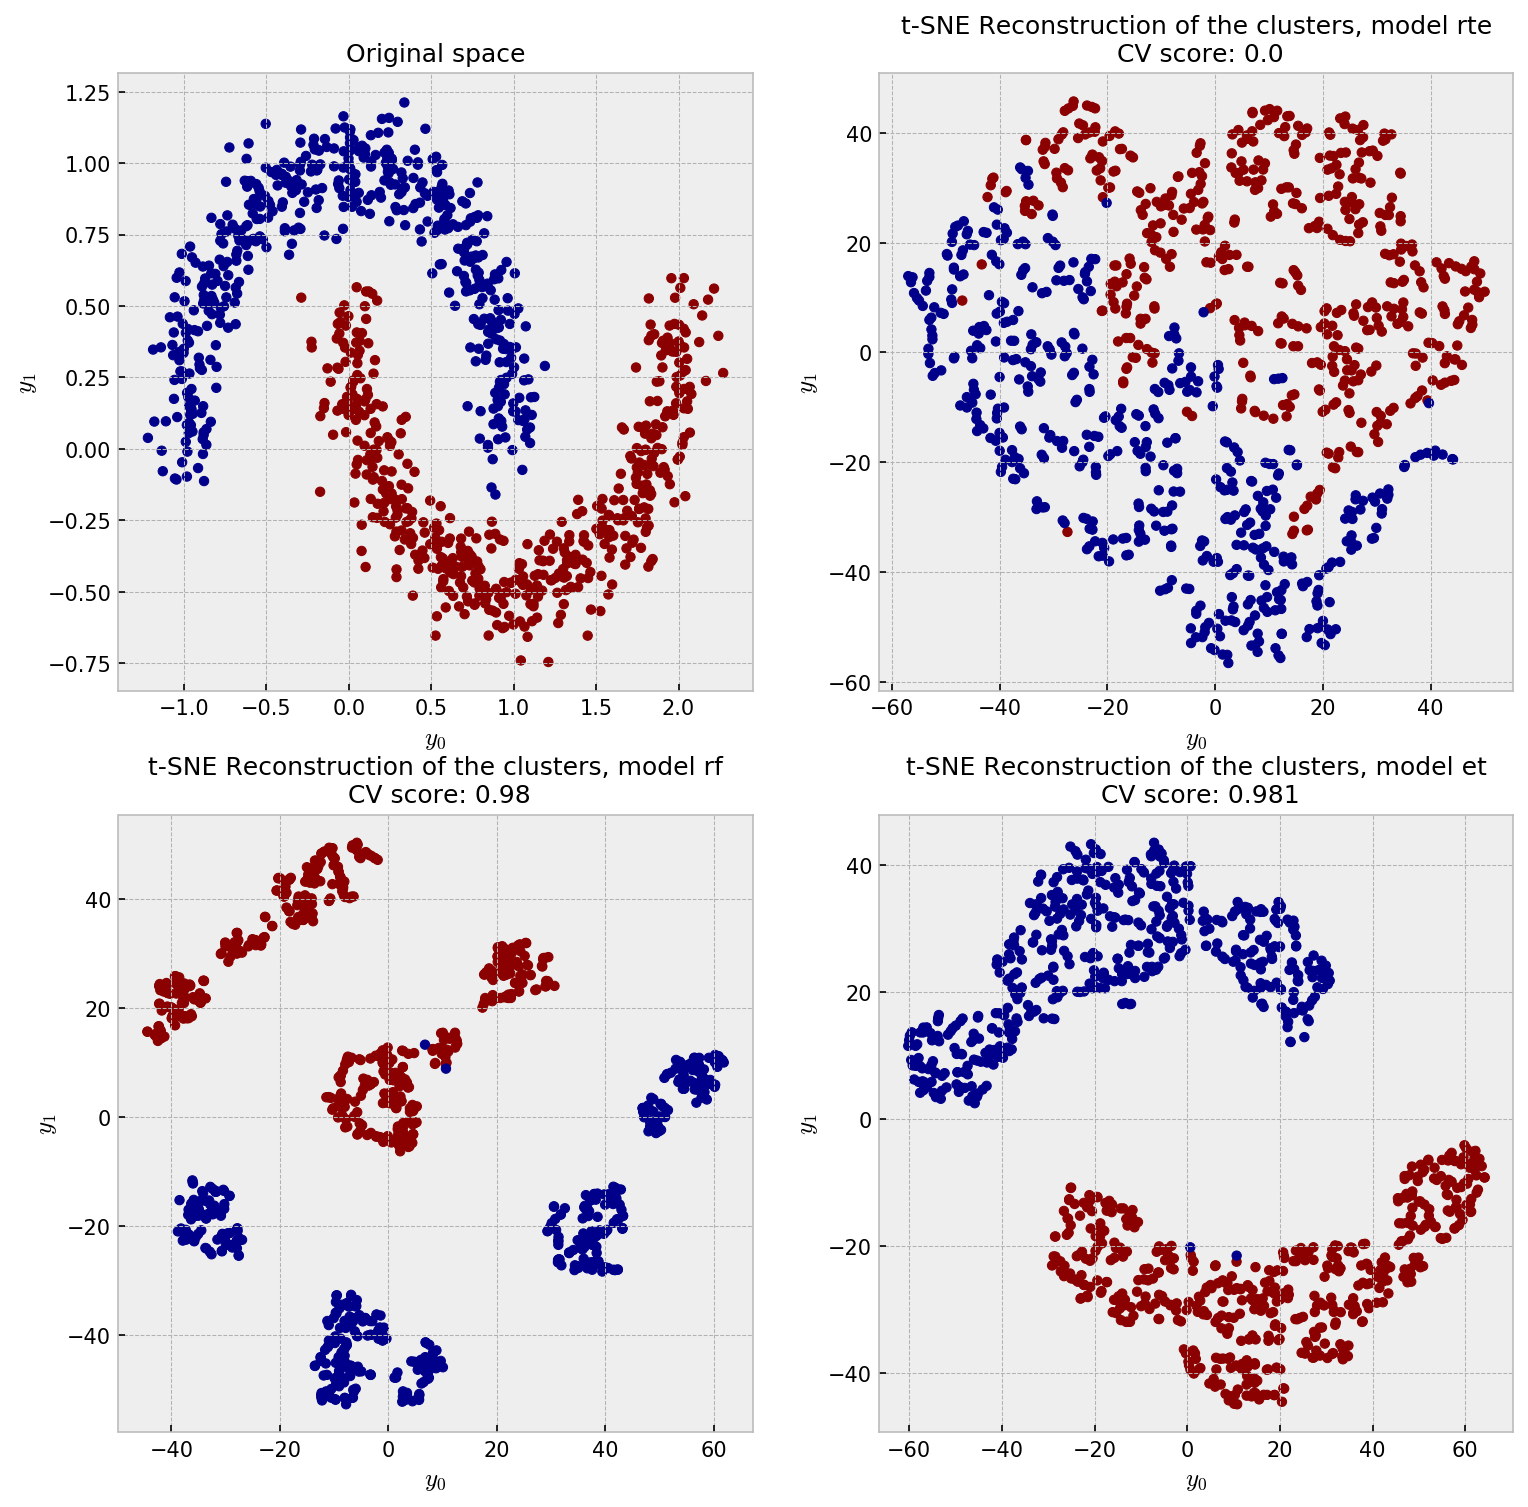

In [24]:
# opening figure
plt.figure(figsize=(12,12), dpi=150);

# first subplot is for drawing the original space
plt.subplot(2, 2, 1)

# let us visualize the clusters
plt.title('Original space', fontsize=12)
plt.scatter(X[:,0], X[:,1], c=pd.Series(y).replace({0:'darkblue',1:'darkred'}), s=20)
plt.ylabel('$y_1$'), plt.xlabel('$y_0$');

# loop for each result
for i, results in enumerate(results_list):

    # current subplot
    plt.subplot(2, 2, i + 2)
    
    # let us visualize the clusters
    plt.title('t-SNE Reconstruction of the clusters, model {0}\n CV score: {1}'.format(results['model_name'], results['cv_score']), fontsize=12)
    plt.scatter(results['tsne_embed'][:,0], results['tsne_embed'][:,1], c=pd.Series(y).replace({0:'darkblue',1:'darkred'}), s=20)
    plt.ylabel('$y_1$'), plt.xlabel('$y_0$');

As expected, supervised models outperform the unsupervised model in this case. RTE suffers with the noisy dimensions and shows a meaningless embedding. RF, with its binary-like similarities, shows artificial clusters, although it shows good classification performance. ET wins this competition showing only two clusters and slightly outperforming RF in CV.  

## Real case: Boston housing dataset

Let us now try our models out with a real dataset. 

##### Let us use sklearn's facility to download the Boston housing dataset and try it out

In [25]:
# loading
dataset = load_boston()
X = pd.DataFrame(dataset['data'], columns=dataset['feature_names'])
y = dataset['target']

In [26]:
# let us take a look at the data
X.head()

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  
0     15.3  396.90   4.98  
1     17.8  396.90   9.14  
2     17.8  392.83   4.03  
3     18.7  394.63   2.94  
4     18.7  396.90   5.33

##### Now, let us run our models 

In [27]:
# let us define our forest models for embedding
# starting with empty dict
models_dict = {}

# unsupervised
models_dict['rte'] = RandomTreesEmbedding(n_estimators=100, max_depth=None, min_samples_leaf=2)

# supervised, random forest
models_dict['rf'] = RandomForestRegressor(n_estimators=100, min_samples_leaf=10)

# supervised, extra trees
models_dict['et'] = ExtraTreesRegressor(n_estimators=100, min_samples_leaf=5)

In [28]:
# list of result dictionaries
results_list = []

# loop for each model
for key, model in tqdm(models_dict.items()):
    
    # starting up a experiment
    experiment = ForestEmbedding(model, X, y, cv_eval_metric='r2')
    
    # computing results
    results = experiment.get_embedding_eval()
    
    # adding model name
    results['model_name'] = key
    
    # storing
    results_list.append(results)

100%|██████████| 3/3 [00:41<00:00, 13.81s/it]


##### Let us visually inspect the similarities learned by the embedding. We use the unsupervised embedding as the ground truth for this visualization.

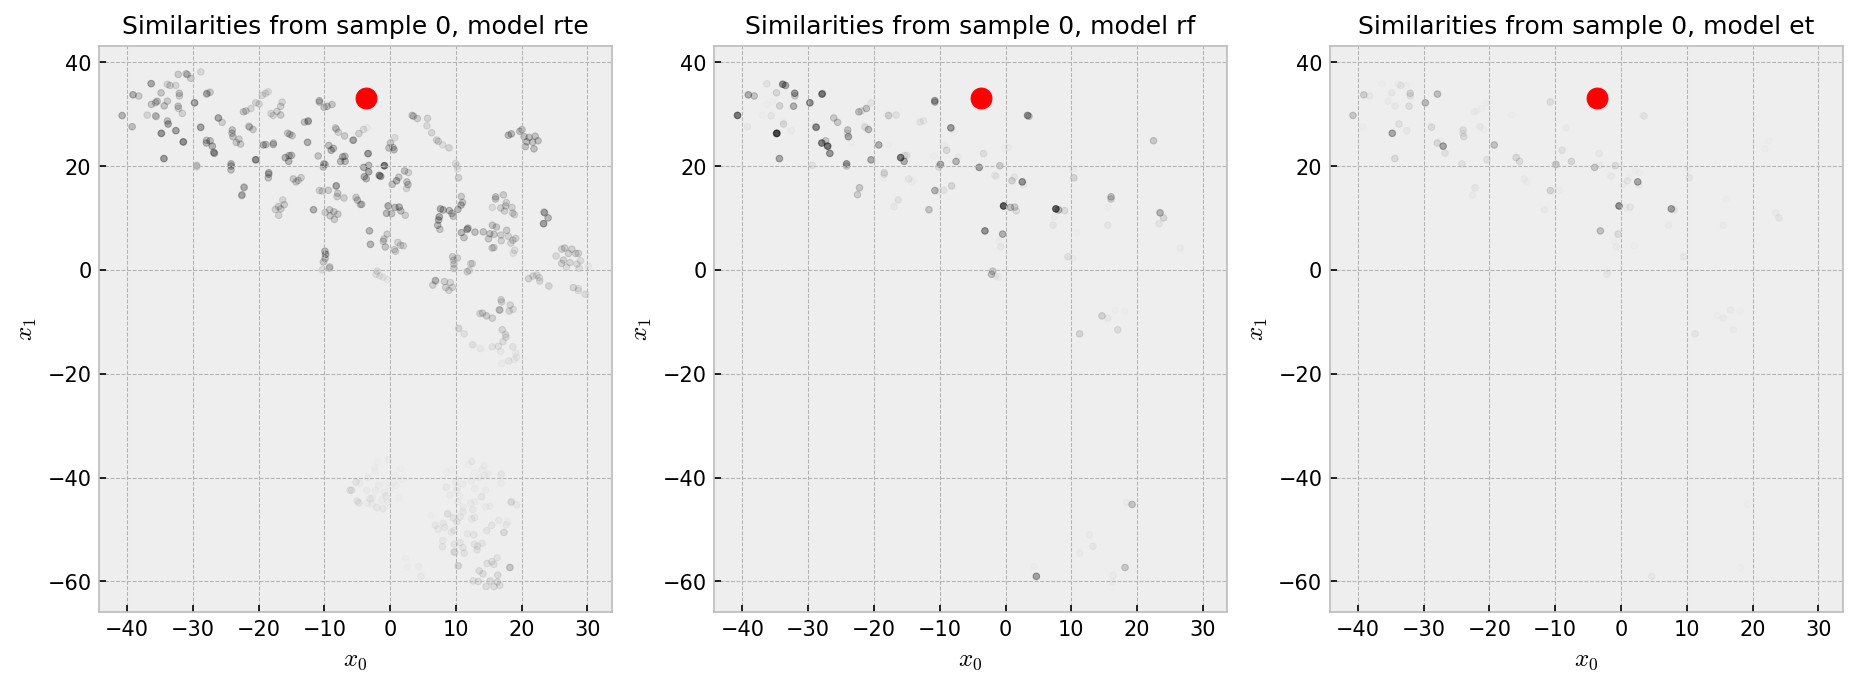

In [29]:
# which point will we inspect?
TARGET_SAMPLE = 0

# opening figure
plt.figure(figsize=(15,5), dpi=150);

# loop for each result
for i, results in enumerate(results_list):

    # current subplot
    plt.subplot(1, 3, i + 1)
    
    # let us define an array for color and alpha
    rgba_colors = np.zeros((results_list[0]['tsne_embed'].shape[0], 4))
    rgba_colors[:,3] = MinMaxScaler().fit_transform(1 - results['D'][TARGET_SAMPLE, :].T).T[0]

    # let us visualize the clusters
    plt.title('Similarities from sample {0}, model {1}'.format(TARGET_SAMPLE, results['model_name']), fontsize=12)
    plt.scatter(results_list[0]['tsne_embed'][:,0], results_list[0]['tsne_embed'][:,1], color=rgba_colors, s=10)
    plt.scatter(results_list[0]['tsne_embed'][TARGET_SAMPLE,0], results_list[0]['tsne_embed'][TARGET_SAMPLE,1], c='red', s=100)
    plt.ylabel('$x_1$'), plt.xlabel('$x_0$');

##### Let us now check a t-SNE plot for our embedding distance matrix

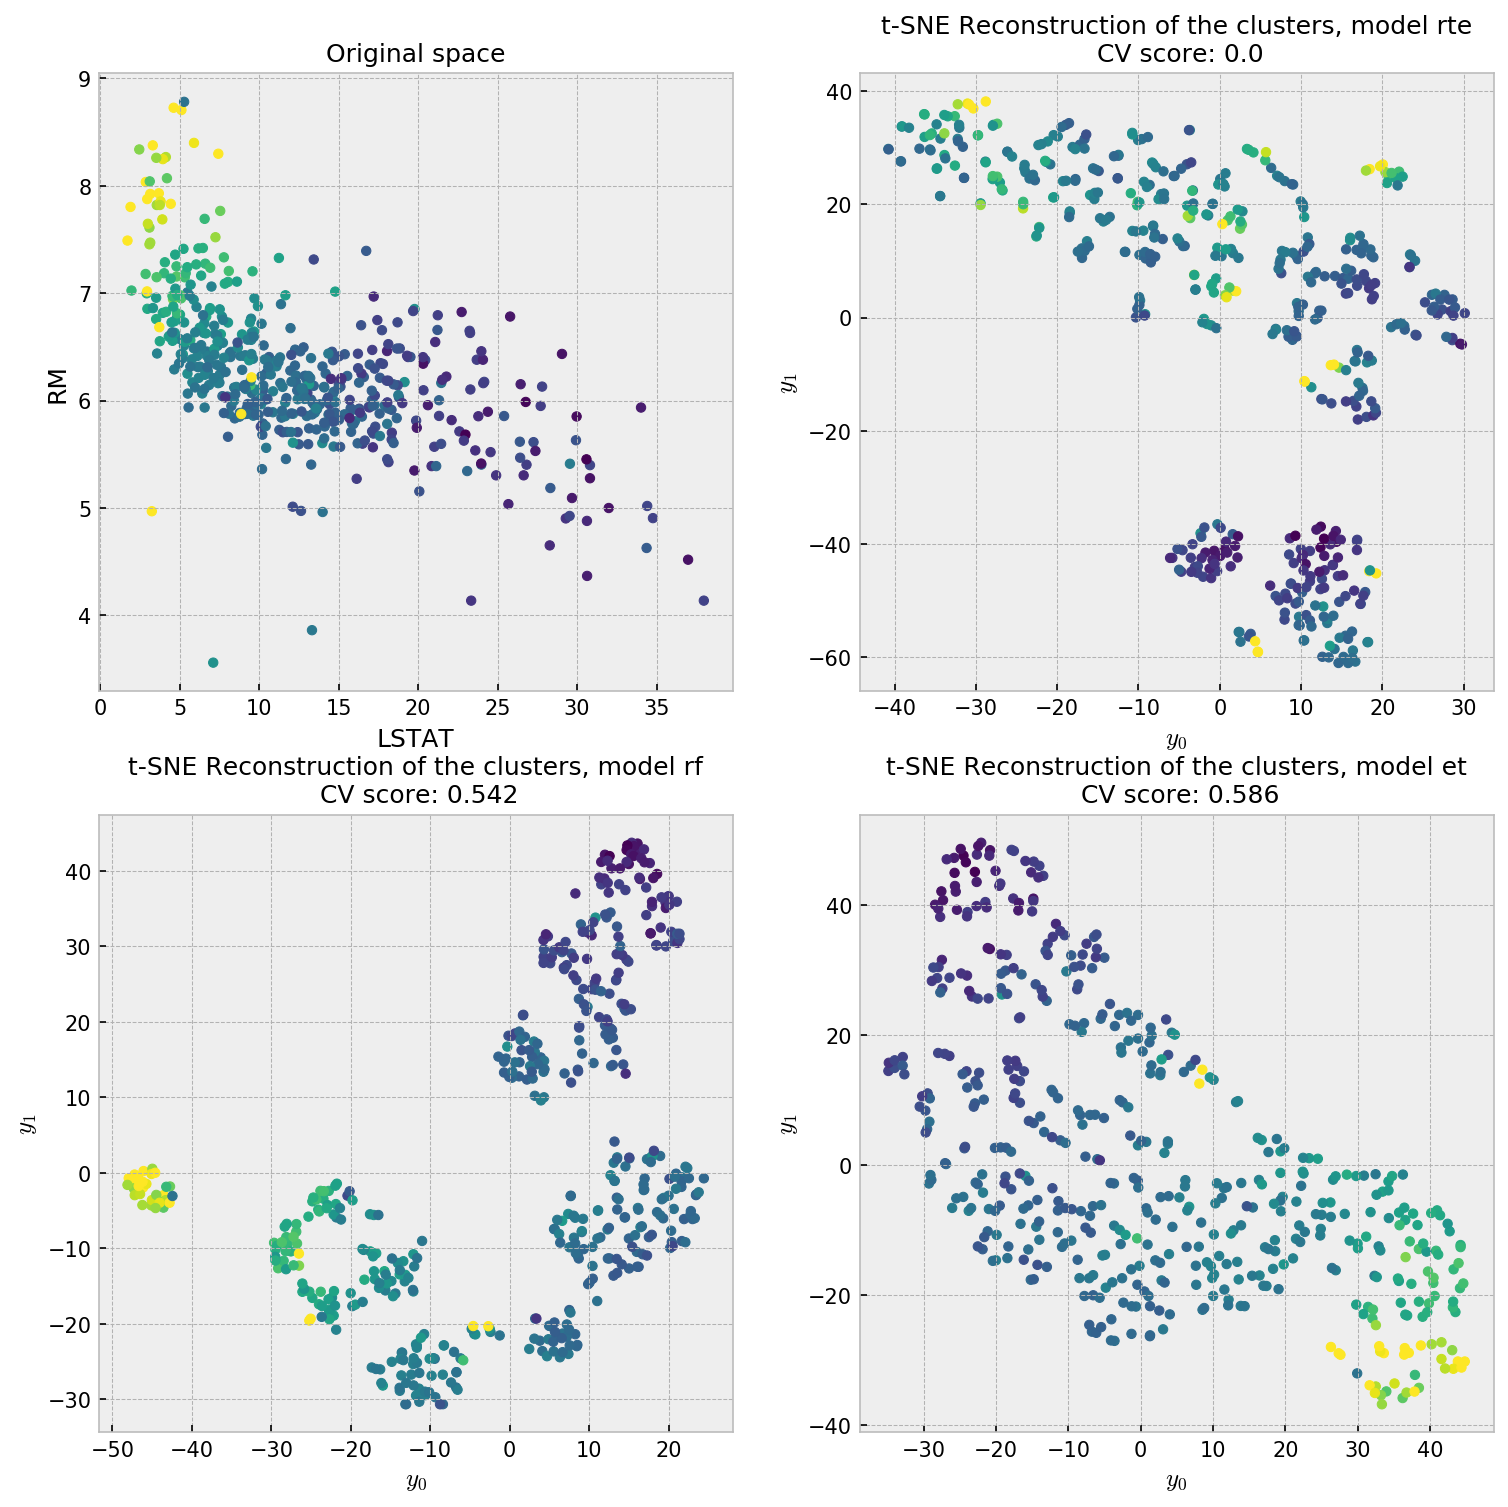

In [30]:
# opening figure
plt.figure(figsize=(12,12), dpi=150);

# first subplot is for drawing the original space
plt.subplot(2, 2, 1)

# let us visualize the clusters
plt.title('Original space', fontsize=12)
plt.scatter(X['LSTAT'], X['RM'], c=pd.Series(y).replace({0:'darkblue',1:'darkred'}), s=20)
plt.ylabel('RM'), plt.xlabel('LSTAT');

# loop for each result
for i, results in enumerate(results_list):

    # current subplot
    plt.subplot(2, 2, i + 2)
    
    # let us visualize the clusters
    plt.title('t-SNE Reconstruction of the clusters, model {0}\n CV score: {1}'.format(results['model_name'], results['cv_score']), fontsize=12)
    #plt.scatter(results['tsne_embed'][TARGET_SAMPLE,0], results['tsne_embed'][TARGET_SAMPLE,1], c='red', s=100)
    plt.scatter(results['tsne_embed'][:,0], results['tsne_embed'][:,1], c=pd.Series(y).replace({0:'darkblue',1:'darkred'}), s=20)
    plt.ylabel('$y_1$'), plt.xlabel('$y_0$');

##### Which are the ost important variables that the model found?

In [32]:
# most important variables?
pd.DataFrame({'var': X.columns, 'imp':results_list[1]['importances']}).sort_values('imp',ascending=False).head(5)

imp    var
5   0.464228     RM
12  0.446976  LSTAT
0   0.026483   CRIM
4   0.016263    NOX
7   0.014588    DIS

The first plot, showing the distribution of the most important variables, shows a pretty nice structure which can help us interpret the results. RTE is interested in reconstructing the data's distribution, so it does not try to put points closer with respect to their value in the target variable. The supervised methods do a better job in producing a uniform scatterplot with respect to the target variable. Considering the two most important variables (90% gain) plot, ET is the closest reconstruction, while RF seems to have created artificial clusters. 

## Conclusion

In this notebook, we compared three different methods for creating forest-based embeddings of data. The unsupervised method Random Trees Embedding (RTE) showed nice reconstruction results in the first two cases, where no irrelevant variables were present. When we added noise to the problem, supervised methods could move it aside and reasonably reconstruct the real clusters that correlate with the target variable. Despite good CV performance, Random Forest showed instability and the embedding, as similarities are a bit binary-like. However, Extremely Randomized Trees provided more stable simialrity measures, showing reconstructions closer to the reality.